In [339]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import seaborn as sns
import matplotlib.pyplot as plt

In [341]:
train = pd.read_csv("train.csv")

In [342]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [343]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [344]:
train['locationnan'] = train['location'].isna()
train['keywordnan'] = train['keyword'].isna()

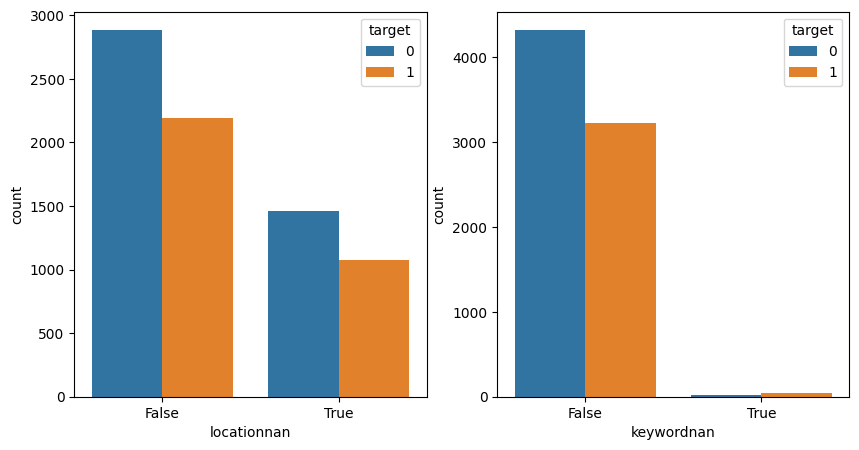

In [349]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))

sns.countplot(data = train, x='locationnan', hue="target", ax=ax[0])
sns.countplot(data = train, x='keywordnan', hue="target", ax=ax[1])

plt.show()

## Inspection of NaNs, above

It seems like rows with location as nan are equally likely to be a disaster tweet or not.  

However for keyword, when we do have a nan, it is more likely that it is from a disaster tweet. This sample size is very small, only at 61, so would not be reliable. 

In light of this, NaNs have little predictive value

In [350]:
train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [331]:
train

,id,keyword,location,text,target
0,1,NaN,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,NaN,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Unknown,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,Unknown,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,Unknown,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,Unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,Unknown,Police investigating after an e-bike collided ...,1


In [40]:
df = train[['text', 'target']]

In [325]:
randints = np.random.randint(low=1, high=len(df), size=8)
for index in randints:
    print(df['text'].iloc[index])
    print(df['target'].iloc[index])
    print("--------------------------------")

Preacher faces UK terrorism charges http://t.co/daPlllFuqK
1
--------------------------------
ISIS claims responsibility for Saudi mosque suicide bombing http://t.co/Wpilp4mymf http://t.co/8NHD9iDaJs
1
--------------------------------
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...
1
--------------------------------
Police: Assailant in latest US movie theatre attack was homeless had psychological issues http://t.co/zdCvlYq6qK
1
--------------------------------
LOOOOOOL
0
--------------------------------
I am a wreck
0
--------------------------------
You can't fight fate and you can't survive alone... I can't help but notice that almost seems like a definition of who I am...
0
--------------------------------
#EMERGENCY in Odai Bucharest Romania 600 Dogs Dying!They are so Hungry that they EAT EACH OTHER! http://t.co/pjigXPVPl0
1
--------------------------------


In [317]:
df['text'].iloc[50]

'Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k'

In [ ]:
train_text, test_texts, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

encodings = tokenizer(
    list(train_text),
    truncation=True,
    padding=True,
    return_tensors="pt"
)


train_labels = torch.tensor(list(train_labels))

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)



model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


In [ ]:
train_dataset = TweetDataset(encodings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:

device = torch.device("cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)


In [ ]:
model.train()

for batch in train_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    
    outputs = model(**batch)
    loss = outputs.loss
    logits = outputs.logits

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Loss: {loss.item():.4f}")


Loss: 0.5839
Loss: 0.5202
Loss: 0.5966
Loss: 0.6829
Loss: 0.6250
Loss: 0.5075
Loss: 0.5388
Loss: 0.3320
Loss: 0.8510
Loss: 0.6195
Loss: 0.7686
Loss: 0.4692
Loss: 0.4630
Loss: 0.4105
Loss: 0.3445
Loss: 0.5447
Loss: 0.4637
Loss: 0.5097
Loss: 0.6369
Loss: 0.4873
Loss: 0.3478
Loss: 0.5470
Loss: 0.4272
Loss: 0.4477
Loss: 0.1620
Loss: 0.5176
Loss: 0.7186
Loss: 0.3086
Loss: 0.6826
Loss: 0.3337
Loss: 0.4256
Loss: 0.6674
Loss: 0.2074
Loss: 0.2918
Loss: 0.2309
Loss: 0.3421
Loss: 0.3959
Loss: 0.6157
Loss: 0.2824
Loss: 0.6359
Loss: 0.3064
Loss: 0.4443
Loss: 0.4194
Loss: 0.3326
Loss: 0.9103
Loss: 0.6632
Loss: 0.6336
Loss: 0.5164
Loss: 0.2883
Loss: 0.3287
Loss: 0.3523
Loss: 0.4071
Loss: 0.2215
Loss: 0.3651
Loss: 0.4121
Loss: 0.6252
Loss: 0.6765
Loss: 0.5286
Loss: 0.3750
Loss: 0.4144
Loss: 0.5483
Loss: 0.4361
Loss: 0.3055
Loss: 0.3823
Loss: 0.4681
Loss: 0.3412
Loss: 0.6217
Loss: 0.5356
Loss: 0.5770
Loss: 0.3800
Loss: 0.4267
Loss: 0.4374
Loss: 0.2637
Loss: 0.4492
Loss: 0.5294
Loss: 0.4406
Loss: 0.4577

In [57]:
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    return_tensors="pt"
)
test_labels = torch.tensor(list(test_labels))
test_dataset = TweetDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16)


In [58]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.8267


# test

In [59]:
test = pd.read_csv("test.csv")

In [60]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [61]:
test_df = test[['id', 'text']]

In [62]:
test_df

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [63]:
test_encodings = tokenizer(
    list(test_df['text']),
    truncation=True,
    padding=True,
    return_tensors='pt'
)


In [64]:
class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}
    
    def __len__(self):
        return len(self.encodings['input_ids'])

test_dataset = TestDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=16)


In [65]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())


In [66]:
import pandas as pd

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})


In [67]:
submission_df.to_csv("submission.csv", index=False)


# practice